## graph creation notebook

In [1]:
import matplotlib
from matplotlib import pyplot as plt
import glob
import os

import networkx as nx
import fiona
import geopandas as gpd
from shapely.geometry import Point, Polygon, shape
from shapely.geometry.multilinestring import MultiLineString
from shapely.geometry.linestring import LineString
from shapely.geometry.collection import  GeometryCollection 
from descartes.patch import PolygonPatch
import pandas as pd
import numpy as np

# some custom files
from img_helpers import get_all_images_in_folder, return_polygons
from helper_functions import getpolygons, make_single_string_object,drop_columns_and_add_one,check_order

# to display images inline
get_ipython().magic(u'matplotlib inline')



## some setup for directories paths etc

In [19]:
folder_polygons = 'D:/allegoria/topo_ortho/ING_processed_margo/moselle/'
# load csv of the images saved previously part
excelPaths = sorted(glob.glob(folder_polygons +'*/*.csv'))
csv_poly = getpolygons(excelPaths)
imagePaths = sorted(glob.glob(folder_polygons +'*/*img.png'))
check_order(imagePaths, excelPaths)
print("Saved csv polygons are loaded correctly there %d ."%(len(csv_poly)))


Check the folder correspondence! Error in the check order funtion
Saved csv polygons are loaded correctly there 6000 .


In [21]:
global_path = "D:/allegoria/datasets_alegoria/BD/BD_topo/moselle/BDTOPO_3-0_TOUSTHEMES_SHP_LAMB93_D057_2019-03-19/BDTOPO/1_DONNEES_LIVRAISON_2019-03-00260/BDT_3-0_SHP_LAMB93_D057-ED2019-03-19/"

## LOAD all the shapefiles as data frames

## roads

In [23]:
# #2019
# # load all the shapely files related to ROADS
fp_road = global_path + "TRANSPORT/troncon2019.shp"
data_road_troncon =  gpd.read_file(fp_road)
all_roads=  data_road_troncon

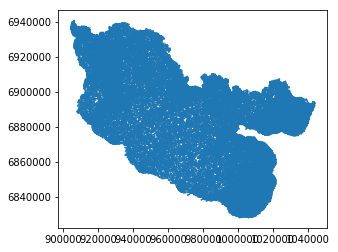

In [24]:
all_roads.plot()

## rivers

875

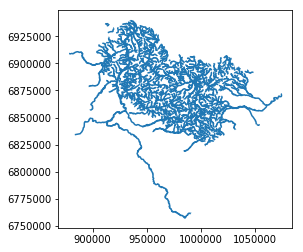

In [25]:
fp_water =  global_path + "HYDROGRAPHIE/COURS_D_EAU.shp"
all_water = gpd.read_file(fp_water)
all_water.plot()
len(all_water)



## Main loop to save sub-shape files for each image
I go through the images and save the vector data inside their boundaries as shape files

In [10]:
import math
def remove_dublicates(list_of_points, threshold = 5):
    #for all points find the closest ones
    ''' remove the pair of points if the dist between them is less than a threshold'''
    filtered_list = list_of_points.copy()
    indexes_to_delete = []
    for i in range(len(list_of_points)-1):
        point1 = list_of_points[i][1] # end of the line
        for j in range(i, len(list_of_points)):
            point2 = list_of_points[j][0] # begining of the line
            dist_eucl = (math.sqrt((point1[0]-point2[0]) ** 2 + (point1[1]-point2[1]) ** 2 ))
        # now add the point to the new list only if there is no element closer than the threshold
            if dist_eucl < threshold:
            # merge the line in one
                filtered_list[i][1] = filtered_list[j][1] # end of first list is now the end of the second
                indexes_to_delete.append(list_of_points[j])
   
    for el in indexes_to_delete:
        try:
            filtered_list.remove(el)
        except ValueError:
            continue
    return filtered_list
        

In [9]:
def filter_graph(g, threshold = 5):    
    """ remove all nearly dublicates from a graph nodes"""
    g_copy = g.copy()
    nodes = list(g.nodes)
    nodes_to_filter = []
    for i in range(len(nodes)-1):
        n1 = nodes[i]
        for j in range(i+1, len(nodes)):
            n2 = nodes[j]
            if (math.sqrt((n1[0]-n2[0]) ** 2 + (n1[1]-n2[1]) ** 2 )) < threshold:
                try:
                    g_copy = nx.contracted_nodes(g_copy, n1, n2)
                    print('succesfully merged two nodes')
                except:
                    print('failed to merge nodes')

    return g_copy 
   
        

In [8]:
#first dome setup
def add_important_points(line1, line2, list_of_important_points, coordinates, gp_frame, shp, shp2):
    '''function ads important points from line interestections. Also, it handles different cases when line interestion is:
    a line, a line and a point, multi-lline etc'''
    #check geo type
    if isinstance(coordinates, MultiLineString) or isinstance(coordinates, LineString):
        pass
    # I ignore the lines                       
    elif isinstance(coordinates, GeometryCollection):
        # case when it is a collection of lines and points
        num_crossings = len(coordinates)
        for i in range(len(coordinates)):
            #recursively call the same function
            list_of_important_points = add_important_points(line1, line2, list_of_important_points, coordinates[i], gp_frame,shp, shp2)
    elif isinstance(coordinates,Point):
            list_of_important_points.append([line1.coords[0],(coordinates.x,coordinates.y),gp_frame['Nature'].iloc[shp]]) #start, end, nature
            list_of_important_points.append([line1.coords[-1],(coordinates.x,coordinates.y),gp_frame['Nature'].iloc[shp]]) #start, end, nature
            list_of_important_points.append([line2.coords[0],(coordinates.x,coordinates.y),gp_frame['Nature'].iloc[shp2]]) #start, end, nature
            list_of_important_points.append([line2.coords[-1],(coordinates.x,coordinates.y),gp_frame['Nature'].iloc[shp2]]) #start, end, nature
    else:
        #case when it is maybe smth weird, or a collection of points only
        try:
            num_crossings = len(coordinates)
            for c in range(num_crossings):
                #then we have c  new edges - two crossed lines are divided into 4 parts
                list_of_important_points.append([line1.coords[0],(coordinates[c].x,coordinates[c].y),gp_frame['Nature'].iloc[shp]]) #start, end, nature
                list_of_important_points.append([line1.coords[-1],(coordinates[c].x,coordinates[c].y),gp_frame['Nature'].iloc[shp]]) #start, end, nature
                list_of_important_points.append([line2.coords[0],(coordinates[c].x,coordinates[c].y),gp_frame['Nature'].iloc[shp2]]) #start, end, nature
                list_of_important_points.append([line2.coords[-1],(coordinates[c].x,coordinates[c].y),gp_frame['Nature'].iloc[shp2]]) #start, end, nature
        except:
            print('No type of the intersection is understood, ignoring this data type ', type(coordinates))
    return list_of_important_points

        

# function to create a graph from pandas dataframe
from shapely.geometry.multilinestring import MultiLineString
def create_graph(gp_frame, poly = None):
    ''' function takes the pandas frame and creates the graph, where the nodes are the begining of the lines or
    crossiing points and links are the roads/rivers, the edges also have their nature information.
    Since sometimes the points can be outside of the polygon, one can also pass a polygon, so all the nodes outside of it 
    will be deleted:
    gp_frame = pandas dataframe with geometry column (supports geometry string)
    poly - polygon, all points outside of its coordinates will be deleted
    returns:
    Graph G, where are nodes are points, edges are types of element (nature=road 0 or water 1)
    Protocol: 
    1) Find start and end points of the lines
    2) Split lines at the intersections
    3) Create nodes at the start and end point of each split line and intersection points
    4) check with a polygon if the nodes are within the image borders. Remove if not.

    '''
    net = nx.Graph() # empty graph
    list_of_important_points = [] #empty list where I have the beginings of the line and the endings (start/end point) and crossing points
    #start + end points
    for shp in range(1, len(gp_frame)):
        # the geometry property here may be specific to my shapefile
        line = gp_frame['geometry'].iloc[shp] #get the line
        try:
            list_of_important_points.append([line.coords[0][:2],line.coords[-1][:2], gp_frame['Nature'].iloc[shp]]) #start (x,y), end, nature
        except:
            print('Not a line object encountered')
    # remove near identical points here -> remove all the points which are really close to each other
    list_of_important_points = remove_dublicates(list_of_important_points)
            
    # points crossings
    for shp in range(1, len(gp_frame)): 
    # the geometry property here may be specific to my shapefile
        line1 = gp_frame['geometry'].iloc[shp] #get the line
        for shp2 in range(0, shp-1):
            line2 = gp_frame['geometry'].iloc[shp2] #get the second line
            if line1.intersects(line2):
                coordinates = line1.intersection(line2)
                #check what is the type of interection and add points accordingly
                list_of_important_points = add_important_points(line1, line2, list_of_important_points, coordinates, gp_frame, shp, shp2)

                
    
    # not create a graph from an edgelist
    for edge in list_of_important_points:
        if poly is not None:
            if poly.contains(Point(edge[0])) and poly.contains(Point(edge[1])):
                net.add_edge(edge[0], edge[1],  nature = edge[2]) #add edge with weight, where weight is the nature
            else:
                continue
            
        else:
            net.add_edge(edge[0], edge[1],  nature = edge[2]) #add edge with weight, where weight is the nature
    return net


## SAVE GRAPHS WHERE NODES ARE ROAD Crossings

In [ ]:
# main loop which creates graphs from vector data
for i, poly in enumerate(csv_poly):
    name  = imagePaths[i][:-7] + 'vector.gpickle'
    print(name)
    sg_roads = all_roads[all_roads.geometry.intersects(poly)]  # extract segments of roads
    sg_water = all_water[all_water.geometry.intersects(poly)]  # extract segments of water
    sg_single_roads = make_single_string_object(sg_roads, poly) # remove multistrings
    sg_single_water = make_single_string_object(sg_water, poly)
    sg_single_roads = drop_columns_and_add_one(sg_single_roads, 'roads', year=2019) # remove extra columns
    sg_single_water = drop_columns_and_add_one(sg_single_water, 'water', year = 2019)
    combined_pd = sg_single_roads.append(sg_single_water, ignore_index= True) # in this stage I am ready to save all the sub-images
    if combined_pd.empty:
         G = nx.empty_graph()
    else:
        G = create_graph(gp_frame=combined_pd, poly=poly)
        # filter graph to remove nearly dublicates
        G = filter_graph(G)
        #graph_dict[name] = G 
    nx.write_gpickle(G, name, protocol=4)
    

## Plot the results

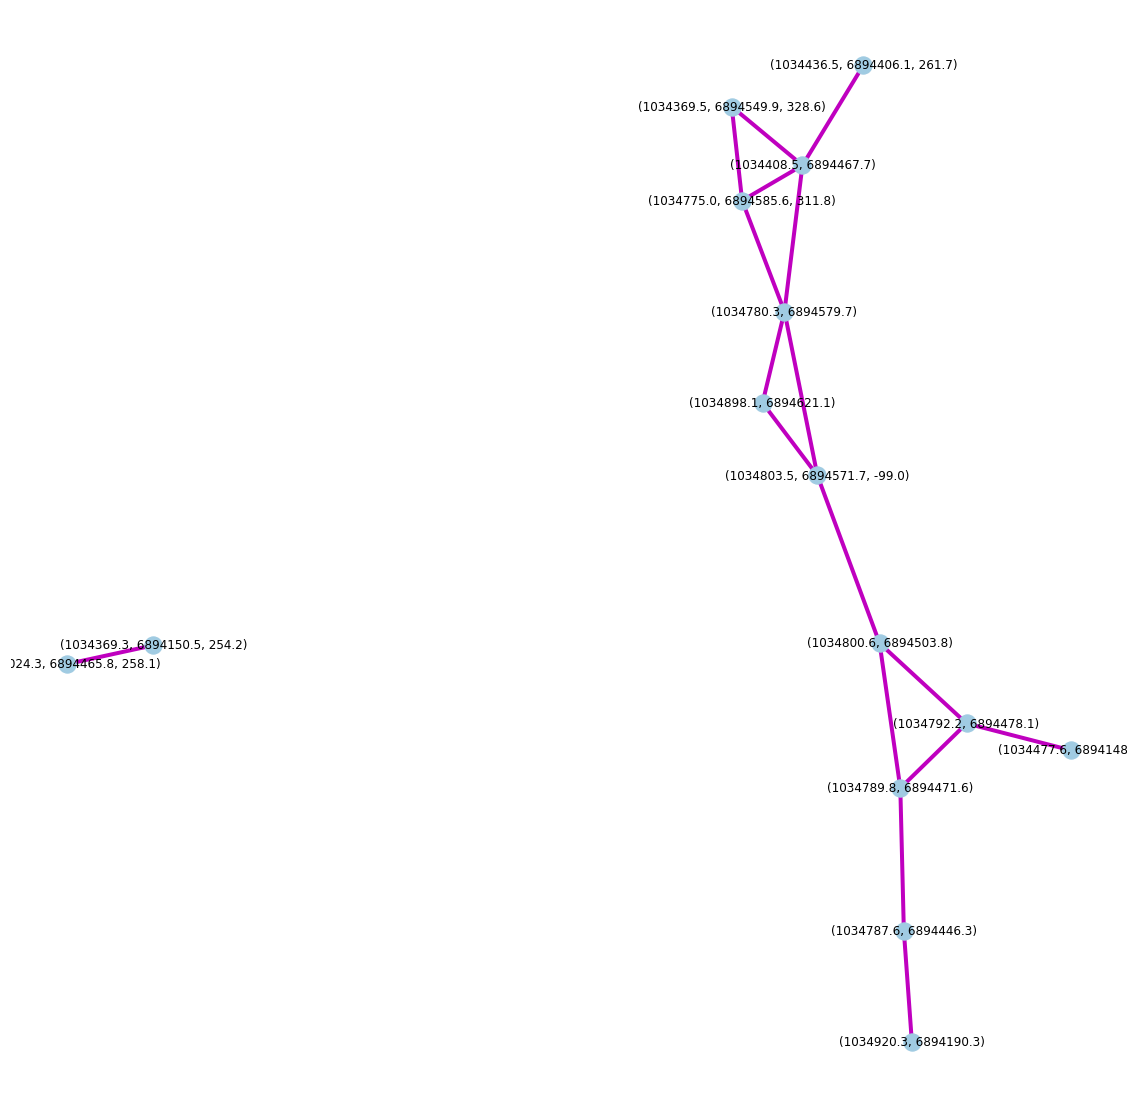

In [238]:
colors =np.repeat('m', len(G.edges))
for i, edge in enumerate(G.edges(data=True)):
    if edge[2]['nature']==1:
        colors[i] = 'b'
fig, ax = plt.subplots(figsize=(20.0, 20.0))        
nx.draw(G,node_color='#A0CBE2',edge_color = colors,width=4,edge_cmap=plt.cm.Blues,with_labels=True)

## Segment -> Graph -> Visualization
This part of the notebook plots my graphs and vector files to show that the graph was made correctly

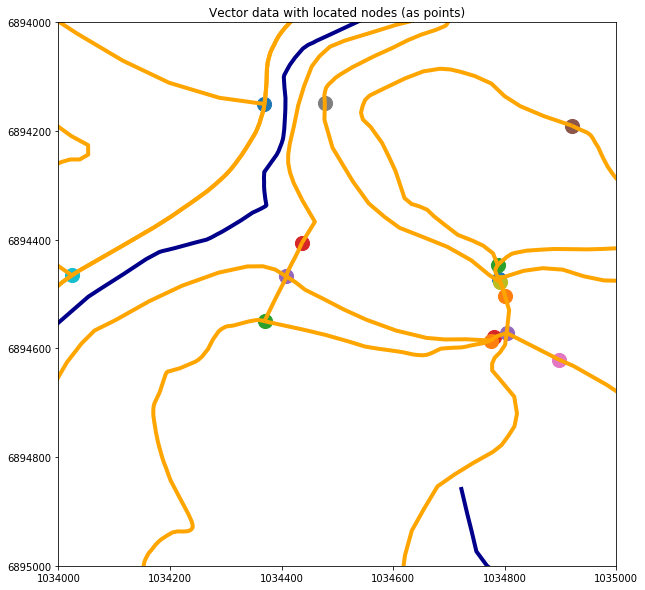

In [240]:
# check if the nodes are correctly extracted
for poly in csv_poly[-1:]:    
    sg_roads = all_roads[all_roads.geometry.intersects(poly)]  # extract segments of roads
    sg_water = all_water[all_water.geometry.intersects(poly)]  # extract segments of water
    fig, ax = plt.subplots(figsize=(10.0, 10.0))
    if not  sg_roads.empty:
        sg_roads.plot(linewidth=4.0, edgecolor='#FFA500', color='#FFA500', ax=ax)
    if not sg_water.empty:
        sg_water.plot(linewidth=4.0, edgecolor='#00008B', color='#00008B', ax=ax)
    for n in G.nodes:      
        ax.scatter(n[0],n[1], marker="o", s=200, label=str(i))
    for e in G.edges:
        ax.plot([e[0][0],e[0][1]], [e[1][0], e[1][1]], 'gray', linestyle=':',label = 'l'+str(i))
    ax.set_xlim([poly.bounds[0],poly.bounds[2]])
    ax.set_ylim([poly.bounds[3],poly.bounds[1]])
    ax.set_title("Vector data with located nodes (as points)")


In [ ]:
## convert to indirected G.to_indirected or view (below)

32

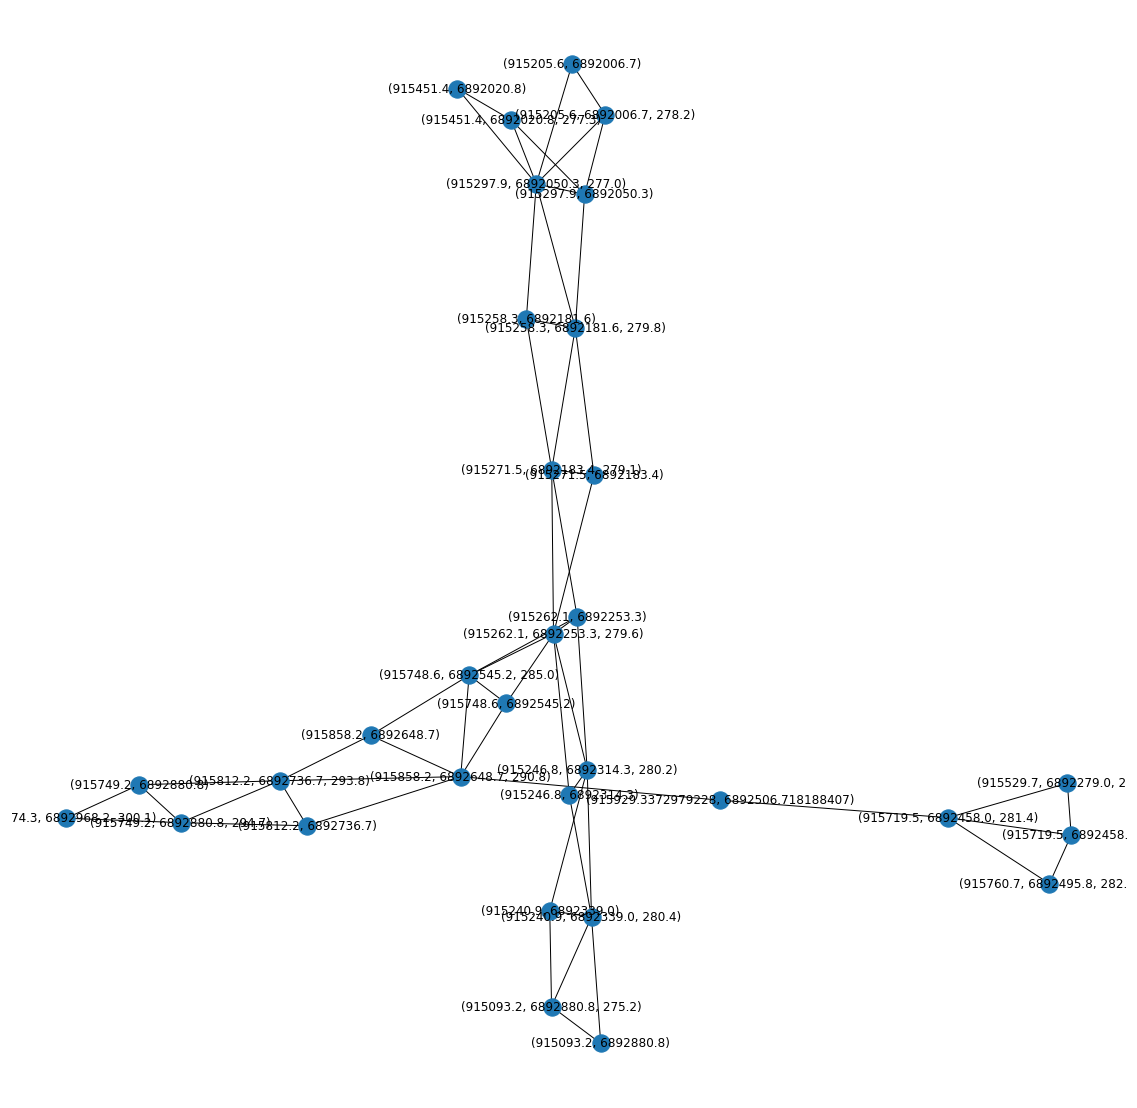

In [35]:
fig, ax = plt.subplots(figsize=(20.0, 20.0))
nx.draw(G, with_labels = True)
len(G)

In [27]:
G.degree

DegreeView({(1034789.8, 6894471.6, 307.4): 5, (1034792.2, 6894478.1, 307.4): 5, (1034787.6, 6894446.3, 308.1): 5, (1034780.3, 6894579.7, 311.6): 3, (1034775.0, 6894585.6, 311.8): 4, (1034920.3, 6894190.3, 329.9): 3, (1034800.6, 6894503.8, 308.6): 3, (1034408.5, 6894467.7, 286.3): 5, (1034436.5, 6894406.1, 261.7): 3, (1034369.5, 6894549.9, 328.6): 5, (1034898.1, 6894621.1, -99.0): 3, (1034803.5, 6894571.7, -99.0): 7, (1034800.6, 6894503.8, -99.0): 3, (1034920.3, 6894190.3, -99.0): 3, (1034787.6, 6894446.3, -99.0): 3, (1034780.3, 6894579.7, -99.0): 3, (1034775.0, 6894585.6, -99.0): 3, (1034408.5, 6894467.7, -99.0): 3, (1034477.6, 6894148.7, -99.0): 3, (1034792.2, 6894478.1, -99.0): 3, (1034024.3, 6894465.8, 258.1): 3, (1034369.3, 6894150.5, 254.2): 3, (1034024.3, 6894465.8): 3, (1034787.6, 6894446.3): 5, (1034792.2, 6894478.1): 5, (1034775.0, 6894585.6): 5, (1034408.5, 6894467.7): 5, (1034369.5, 6894549.9): 2, (1034898.1, 6894621.1): 3, (1034898.1, 6894621.1, 306.3): 1, (1034800.6, 68945

## Create graphs where nodes are roads and rivers and links are connections between them

In [37]:
import math
import numpy as np
import numpy.linalg as la
 

def py_ang(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'    """
    cosang = np.dot(v1, v2)
    sinang = la.norm(np.cross(v1, v2))
    return np.arctan2(sinang, cosang)

def calculate_curvature_histogram(line_object, bins=[0, 0.1, 0.2, 1]):
    '''returns histogram values '''
    geom = line_object.xy
    total_points = len(geom[0])
    curvature = []
    for i in range(0,total_points-2): #make vectors between each pair of line splines
        splain_vector1 = [geom[0][i+1]-geom[0][i], geom[1][i+1]-geom[1][i]]
        splain_vector2 = [geom[0][i+2]-geom[0][i+1], geom[1][i+2]-geom[1][i+1]]
        curvature.append(py_ang(splain_vector1, splain_vector2))
    # then return values for 3 bins
    val = np.histogram(curvature, bins=3, density=False)
    return val[0]/total_points # returne normalized hist values

In [39]:
def get_node_attributes(line_object, poly_bound, nature):
    """ function returns attributes of road node"""
    attributes = {}
    obj_type = nature
    obj_length = line_object.length
    obj_perimeter = poly_bound.length
    obj_normed_length = obj_length/obj_perimeter
    hist_curvature = calculate_curvature_histogram(line_object)
    attributes = {'nature': obj_type, 'normed_length':obj_normed_length, 
                 'curvature_bin1':hist_curvature[0], 'curvature_bin2':hist_curvature[1], 
                 'curvature_bin3':hist_curvature[2]}
    return attributes

In [2]:
from shapely.geometry import Point 
def get_angle_between_roads(line1, line2, intersection):
    '''calculates the angle between lines. The vectors for the angles are the following:
    first line starting point - crossing, second line starting point crossing 
    '''
    if isinstance(intersection, LineString):
        intersection = Point(intersection.coords[0])

    splain_vector1 = [line1.coords[0][0]-intersection.x, line1.coords[0][1]-intersection.y]
    splain_vector2 = [line2.coords[0][0]-intersection.x, line2.coords[0][1]-intersection.y]
    return py_ang(splain_vector1, splain_vector2)
    

In [41]:
def create_graph_where_object_is_node(gp_frame, poly = None):
    ''' function takes the pandas frame and creates the graph, where the nodes are rivers and roads, the edges signify if they are connected to
    one another (if there is a crossing), edge properties signify the angles of the crossings. 
    Nodes have the following attributes: 
    a) type of object (road/water)
    b) length/polygon_perimeter
    c) - d)  curvature histogram of 3 bins, I will just calculate curvature for all segments and create a histogram of 3 bins
    '''
    net = nx.Graph() # empty graph   
    attr = {}
    for shp in range(0, len(gp_frame)-1): # for each line
        # the geometry property here may be specific to my shapefile
        line1 = gp_frame['geometry'].iloc[shp] #get the line
        # get all line attributes
        attributes = get_node_attributes(line1, poly, gp_frame['Nature'].iloc[shp])
        net.add_node(shp) # add node
        attr[shp]= attributes # nested dict
        for shp2 in range(shp+1, len(gp_frame)):
            line2 = gp_frame['geometry'].iloc[shp2] #get the second line
            if line1.intersects(line2): # if intersects
                #and intersection is within the polygon
                intersection = line1.intersection(line2)
                try:
                    num_intersections = len(intersection) #case there are several intersections
                    for point_int in intersection:
                        if point_int.within(poly):                
                            net.add_edge(shp, shp2, angle = get_angle_between_roads(line1, line2, point_int)) # edge with an attribute
                            continue
                except:                
                    if intersection.within(poly):      # case there is just one intersection           
                        net.add_edge(shp, shp2, angle = get_angle_between_roads(line1, line2, intersection)) # edge with an attribute
                        continue
        # add the last element - coz first loop is not for all values, and last node needs attributes
        attributes = get_node_attributes(line2, poly, gp_frame['Nature'].iloc[shp2])
        attr[len(gp_frame)-1]= attributes # nested dict
        net.add_node(shp2) # add node 
        nx.set_node_attributes(net, attr)
    return net

In [42]:
def drop_columns_and_add_one(pd_df, pd_dataframe_type, year = 2019):
    ''' this function just cleans the df removing extra columns'''
    if year == 2019:
        if pd_dataframe_type == 'roads':
            pd_df =pd_df.drop(['ACCES_PED','ACCES_VL','ALIAS_D','ALIAS_G','BORNEDEB_D','BORNEDEB_G','BORNEFIN_D',
                               'BORNEFIN_G','BUS','CL_ADMIN','SENS','SOURCE','TOPONYME',
                             'TYP_ADRES','URBAIN','VIT_MOY_VL','VOIE_VERTE',
                             'CYCLABLE','C_POSTAL_D','C_POSTAL_G','DATE_APP','DATE_CONF','DATE_CREAT','DATE_MAJ',
                              'DATE_SERV','ETAT','FERMETURE', 'FICTIF','GESTION',
                             'ID_RN','ID_SOURCE','ID_VOIE_D','ID_VOIE_G','IMPORTANCE','INSEECOM_D','INSEECOM_G','PREC_ALTI',
                              'PREC_PLANI','PRIVE','RESTR_H','RESTR_LAR','RESTR_LON','RESTR_MAT','RESTR_P','RESTR_PPE',                             'ITI_CYCL','IT_VERT','LARGEUR','NATURE','NAT_RESTR','NB_VOIES','NOM_1_D','NOM_1_G','NOM_2_D','NOM_2_G','NUMERO',
                              'NUM_EUROP','POS_SOL'], axis=1)    #'STATUT_TOP',    'TYPE_ROUTE' 
            pd_df['Nature'] = 0

        else:       #water
            pd_df = pd_df.drop(['CODE_HYDRO','COMMENT','DATE_APP', 'DATE_CONF','DATE_CREAT','DATE_MAJ',
                                          'SOURCE','STATUT','STATUT_TOP','TOPONYME',
                                          'ID_SOURCE','IMPORTANCE','MAREE',
                                          'PERMANENT'], axis=1)

            pd_df['Nature'] = 1
            
            
            
            
    elif year == 2004:
        if pd_dataframe_type == 'roads':
            pd_df =pd_df.drop(['PREC_PLANI','PREC_ALTI','NATURE','NUMERO','NOM_RUE_G','NOM_RUE_D',
                               'IMPORTANCE','CL_ADMIN','GESTION','CODEVOIE_D','TYP_ADRES','BORNEDEB_G',
                               'BORNEDEB_D','BORNEFIN_G','BORNEFIN_D','ETAT','Z_INI','Z_FIN',
                              'MISE_SERV','IT_VERT','IT_EUROP','FICTIF','FRANCHISST','LARGEUR','NOM_ITI',
                               'NB_VOIES','POS_SOL','SENS','INSEECOM_G','INSEECOM_D','CODEVOIE_G'], axis=1)        
            pd_df['Nature'] = 0
        else:    #water
            pd_df = pd_df.drop(['PREC_PLANI','PREC_ALTI','ARTIF','FICTIF','FRANCHISST',
                                'NOM','POS_SOL','REGIME','Z_INI','Z_FIN'], axis=1)
            pd_df['Nature'] = 1

       
       
    return pd_df


In [ ]:
# main loop which creates graphs from vector data
for i, poly in enumerate(csv_poly):
    name  = imagePaths[i][:-7] + 'road_vector.gpickle'
    print(name)
    sg_roads = all_roads[all_roads.geometry.intersects(poly)]  # extract segments of roads
    sg_water = all_water[all_water.geometry.intersects(poly)]  # extract segments of water
    sg_single_roads = make_single_string_object(sg_roads, poly) # remove multistrings
    sg_single_water = make_single_string_object(sg_water, poly)
    sg_single_roads = drop_columns_and_add_one(sg_single_roads, 'roads', year=2019) # remove extra columns
    sg_single_water = drop_columns_and_add_one(sg_single_water, 'water', year = 2019)
    combined_pd = sg_single_roads.append(sg_single_water, ignore_index= True) # in this stage I am ready to save all the sub-images
    if combined_pd.empty:
         G = nx.empty_graph()
    else:
        G = create_graph_where_object_is_node(gp_frame=combined_pd, poly=poly)
    nx.write_gpickle(G, name, protocol=4)
    

### some visualizations of the results

{(1, 2): <matplotlib.text.Text at 0x1cca2e6bd68>,
 (1, 3): <matplotlib.text.Text at 0x1cca2e6b438>,
 (2, 3): <matplotlib.text.Text at 0x1cca2d73f98>}

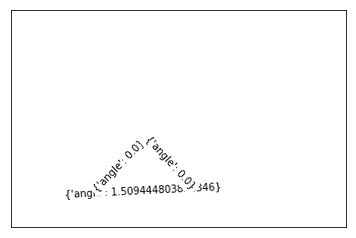

In [35]:
nx.draw_networkx_edge_labels(G,pos=nx.spring_layout(G))

In [490]:
print(G.nodes[0])

{'nature': 0, 'normed_length': 0.12061614119159085, 'curvature_bin1': 0.5, 'curvature_bin2': 0.3, 'curvature_bin3': 0.13333333333333333}


In [498]:
print(G.get_edge_data(1,0 )['angle'])

0.0


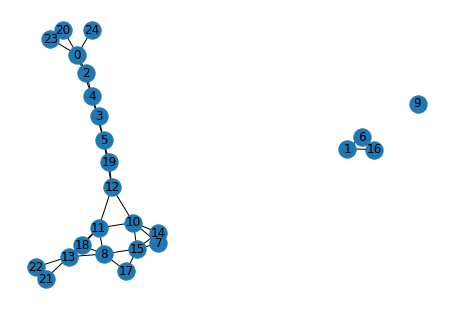

In [310]:
nx.draw(G,with_labels=True)

In [279]:
G.nodes[0]['curvature_bin1']

14.939098698853318

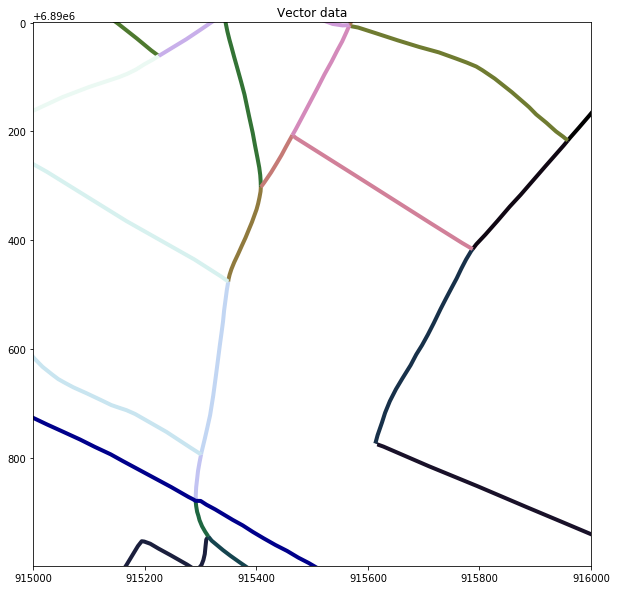

In [340]:
# check if the nodes are correctly extracted
for poly in csv_poly[0:1]:    
    sg_roads = all_roads[all_roads.geometry.intersects(poly)]  # extract segments of roads
    sg_water = all_water[all_water.geometry.intersects(poly)]  # extract segments of water
    fig, ax = plt.subplots(figsize=(10.0, 10.0))
    if not sg_roads.empty:
        sg_roads.plot(linewidth=4.0,cmap='cubehelix', ax=ax) #, edgecolor='#FFA500', color='#FFA500',
    if not sg_water.empty:
        sg_water.plot(linewidth=4.0, edgecolor='#00008B', color='#00008B', ax=ax)
#     for n in G.nodes:      
#         ax.scatter(n[0],n[1], marker="o", s=200, label=str(i))
#     for e in G.edges:
#         ax.plot([e[0][0],e[0][1]], [e[1][0], e[1][1]], 'gray', linestyle=':',label = 'l'+str(i))
  
    ax.set_xlim([poly.bounds[0],poly.bounds[2]])
    ax.set_ylim([poly.bounds[3],poly.bounds[1]])
    ax.set_title("Vector data")
